In [2]:
import os
import pandas as pd
import numpy as np

from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

import cufflinks as cf 
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from matplotlib import pyplot as plt
import seaborn as sns

# 中文NLP工具
from string import punctuation
import re

import tqdm 
tqdm.tqdm_notebook().pandas()

pd.set_option('display.max_rows', 300)

In [3]:
df = pd.read_csv('../data/aggregated_data.csv')

In [5]:
df['date'] = pd.to_datetime(df['date'])
df['date'].min(), df['date'].max()

(Timestamp('2020-03-17 00:00:00'), Timestamp('2020-05-30 00:00:00'))

## EDA

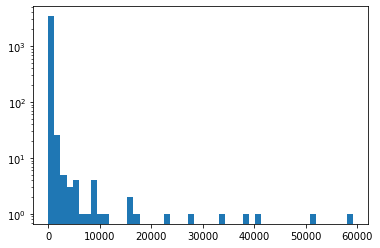

In [7]:
plt.hist(df['nb_interactivity'], bins= 50)
plt.yscale('log')

In [8]:
data = df.groupby('date').agg({'微博正文' : 'count', '转发数':'sum'})[['微博正文','转发数']].reset_index()
data['平均转发数'] = data['转发数']/data['微博正文']
fig = px.bar(data_frame=data, y='微博正文',x='date',text='微博正文')
fig.update_layout(width=1000, title = '五个一政策-每日原创微博数')
fig.show()


In [9]:
fig = df.发布者地区.value_counts().iloc[:15].iplot(kind='barh', asFigure=True)
fig.update_layout(height=400, title='微博发布者所在地区 Count')

In [10]:
df[['转发数','评论数','点赞数']].quantile(0.99)

转发数     122.68
评论数     339.72
点赞数    1520.32
Name: 0.99, dtype: float64

In [11]:
# 关注度

delays = (df['date']-df['date'].min()).dt.days
# color_pallet = sns.color_palette('RdBu_r',delays.max()+1)

fig=go.Figure(layout=dict(width=800, height=700, title='五个一政策 话题关注度 - 颜色越浅,发布时间越久'))

trace = go.Scatter(
    x=df['发布者粉丝数'],
    y=df['nb_interactivity'],
    opacity=0.7,
    mode='markers',
    marker=dict(
        size=delays/5,
        color=delays[::-1]
    ),
    text=df['date'].dt.date
)

fig.add_trace(trace)
fig.update_layout(
    yaxis={'type':'log', 'title':'互动次数 - log'}, 
    xaxis={'type':'log', 'title':'发布者粉丝数 - log'})
fig.show()

## 情感分析

In [15]:
df['positive'] = 0
df['negative'] = 0
df['neutre'] = 0

df.loc[df['sentiment'] == 2, 'positive'] = 1
df.loc[df['sentiment'] == 0,'negative'] = 1
df.loc[df['sentiment'] == 1,'neutre'] = 1

In [16]:
import plotly.figure_factory as ff

# 不同情感的微博每日数量
data = df.groupby('date').agg({
    'positive':'sum',
    'negative':'sum',
    'neutre':'sum',
    })

# data = pd.DataFrame(data.values / data.sum(axis=1).values.reshape(-1,1), index=data.index, columns=data.columns)

data = pd.melt(data.reset_index(), id_vars='date', value_vars=['positive','negative','neutre'])

fig = px.bar(data_frame=data, x='date',y='value',color='variable', )
fig.update_layout(
    height=300,
    width=800,
    title='情感分析变化 数值')
fig.show()

# 不同情感的微博每日比例
data = df.groupby('date').agg({
    'positive':'sum',
    'negative':'sum',
    'neutre':'sum',
    })

data = pd.DataFrame(data.values / data.sum(axis=1).values.reshape(-1,1), index=data.index, columns=data.columns)

data = pd.melt(data.reset_index(), id_vars='date', value_vars=['positive','negative','neutre'])

fig = px.bar(data_frame=data, x='date',y='value',color='variable', )
fig.update_layout(
    height=300,
    width=800,
    title='情感分析变化 相对比例')
fig.show()

# 置信度
fig = ff.create_distplot([df.loc[df['sentiment'] == 2, 'confidence'].values,
                          df.loc[df['sentiment'] == 0, 'confidence'].values], ['Positive', 'Negative'], bin_size=[0.05, .025])
fig.update_layout(width=800, height=300, title='Confidence Distribution')
fig.show()

In [18]:
def add_identity(df):
    
    # 如何界定大V , 50w 粉丝 
    df['if_大V'] = 0
    df.loc[df['发布者粉丝数']>=500000, 'if_大V'] = 1

    # 多粉 少互动
    df['if_官媒'] = 0
    df.loc[(df['nb_interactivity']/(df['发布者粉丝数']+1)) < 0.00002, 'if_官媒'] = 1

    # 多粉 高互动`
    df['if_自媒'] = 0
    df.loc[((df['nb_interactivity']/(df['发布者粉丝数']+1))>0.0005)&(df['发布者粉丝数']>50000), 'if_自媒'] = 1

    # 身份修正
    ## 官媒 list
    l1 = ['中国民航网','']
    df.loc[df['发布者姓名'].isin(l1), 'if_官媒'] = 1
    df.loc[df['发布者姓名'].isin(l1), 'if_自媒'] = 0
    df.loc[df['发布者姓名'].isin(l1), 'if_个人用户'] = 0

    ## 自媒 list
    l2 = ['小qqq阿','胡舒立','FATIII']
    df.loc[df['发布者姓名'].isin(l2), 'if_官媒'] = 0
    df.loc[df['发布者姓名'].isin(l2), 'if_自媒'] = 1
    df.loc[df['发布者姓名'].isin(l2), 'if_个人用户'] = 0

    # 其他 
    df['if_个人用户'] = 0
    df.loc[(df['if_大V'] == 0) & (df['if_官媒'] == 0) & (df['if_自媒'] == 0),'if_个人用户'] = 1

    return df
df = add_identity(df)

In [19]:
df[['if_大V', 'if_官媒','if_自媒','if_个人用户']].sum(axis=0)

if_大V       241
if_官媒       258
if_自媒        71
if_个人用户    2830
dtype: int64

In [127]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=['负面', '中性','正面'], 
                     values=df[df['发布者地区']=='海外']['sentiment'].value_counts().sort_index(), 
                     hole=.6,
                     name = '海外微博情绪'), 1,1)
fig.add_trace(go.Pie(labels=['负面', '中性','正面'], 
                     values=df[df['发布者地区'] !='海外']['sentiment'].value_counts().sort_index(), 
                     hole=.6,
                     name = '非海外微博情绪'), 1,2)

fig.update_traces(hole=0.5, hoverinfo='label+percent+name')
fig.update_layout(
    title_text = '海外/国内 对待五个一政策 微博情感分析',
    annotations=[dict(text='海外', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='国内', x=0.82, y=0.5, font_size=20, showarrow=False)]
)

fig.show()

## 词云

In [102]:
import jieba

jieba.load_userdict('../user_dict/dict.txt')

texts = df['text_preprocessed'].values.tolist()
texts_splited = []
for s in texts:
    texts_splited.append(' '.join([i for i in jieba.cut(s,use_paddle=True)]))

df['texts_splited'] = texts_splited

In [111]:
def get_stopwords(path):
    with open(path, 'r', encoding="utf8") as f:
        stopwords = [line.strip() for line in f.readlines()]    
    stopwords = list(set(stopwords))

    return stopwords

stopwords = get_stopwords('../user_dict/dict.txt') +\
    ['客运','航班','可能','知道','就是','可以','不是','不能','因为','显示','原图','我们','你们']

In [120]:
from wordcloud import WordCloud
def plot_wordcloud(words, path = '../output/词云.png'):
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1500).generate(words)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(path ,dpi=400)

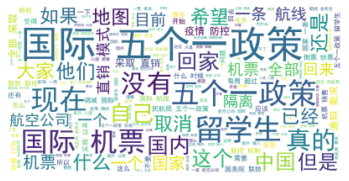

In [123]:
plot_wordcloud(' '.join(texts_splited))

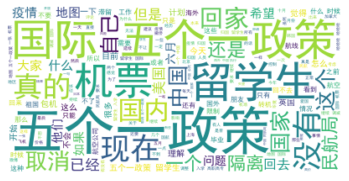

In [125]:
#
plot_wordcloud(' '.join(df[df['发布者地区']=='海外']['texts_splited'].values), '../output/词云_海外.png')

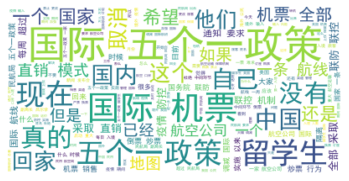

In [126]:
plot_wordcloud(' '.join(df[df['发布者地区']!='海外']['texts_splited'].values), '../output/词云_国内.png')

### Save reformed Data

# TO DO List

- 数据来源分析 
- EDA  <--
    - ~~基本数据情况~~
    - 大V关注度
    - 留学生分析
    - ~~关注度时间变化~~

- 微博情感分析
    - ~~数据预处理~~
    - ~~api~~
    - 自己做模型
    - 